# Test

In [10]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

# Custom libraries
# from milling_tool_env import MillingTool
from utilities import downsample

In [11]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 1
ADD_NOISE = 0
MILLING_OPERATIONS_MAX = 1000

In [12]:
def tool_wear_data(data_file, wear_threshold, normalize=False, add_noise=False, sampling_rate=1):
    ## Read data
    df_raw = pd.read_csv(data_file)

    df = downsample(df_raw, sampling_rate)

    # Reset index as the downsampling disturbs the index and then PPO.learn() fails. Gives a "Key error"
    df = df.reset_index(drop=True)
    n_points = len(df.index)

    # 1. Add white noise for robustness
    if add_noise:
        df['tool_wear'] = df['tool_wear'] + np.random.normal(0, 1, n_points)/add_noise

    # Normalize
    if normalize:
        WEAR_MIN = df['tool_wear'].min() 
        WEAR_MAX = df['tool_wear'].max()
        WEAR_THRESHOLD_NORMALIZED = (wear_threshold-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
        df_normalized = (df-df.min())/(df.max()-df.min())

        # df_normalized['ACTION_CODE'] = np.where(df_normalized['tool_wear'] < WEAR_THRESHOLD_NORMALIZED, 0.0, 1.0)
        # print(f'Tool wear data imported ({n_points} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

        df_train = df_normalized.copy(deep=True)

        tool_wear = df_normalized['tool_wear']
        action_code_normalized = df_normalized['ACTION_CODE']
        action_code = df['ACTION_CODE']
        df_train['ACTION_CODE'] = df['ACTION_CODE']
    else:
        df_train = df.copy(deep=True)
        tool_wear = df['tool_wear']
        action_code = df['ACTION_CODE']

    plt.figure(figsize=(10, 2.5))
    plt.plot(tool_wear, linewidth=1)

    if normalize:
        plt.plot(action_code_normalized, linewidth=1)
        wear_threshold_return = WEAR_THRESHOLD_NORMALIZED
        plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3) 
    else:
        plt.plot(action_code, linewidth=1)
        wear_threshold_return = wear_threshold
        plt.axhline(y = wear_threshold, color = 'r', linestyle = '--', alpha=0.3) 

    plt.title(f'Tool wear')
    plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
    plt.show()

    return tool_wear, action_code, wear_threshold_return, df_train

- Down-sampling. Input data records: 1000. Sampling rate: 1. Expected rows 1000.    Down-sampled to 1000 rows.


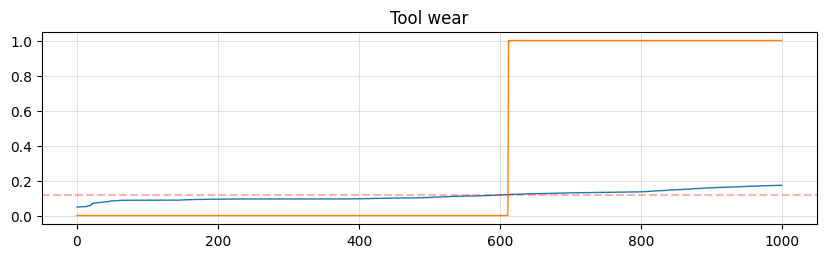

Tool failure RUL threshold at time 950 is 0.006


In [13]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=False, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')
# failure_point = df_train.loc[df_train['ACTION_CODE'] == 1].iloc[0]
# TOOL_FAILURE_TIME = failure_point['time']
# print(f'Tool failure time-point: {TOOL_FAILURE_TIME:3.3f}')

In [71]:
# ------------------------------------------------------------------------------------------------------------------------
# Milling tool environment
# V.1.0 04-Aug-2024
# ------------------------------------------------------------------------------------------------------------------------

import numpy as np
import gymnasium as gym
from gymnasium import spaces

LAMBDA = 0.01
NO_ACTION = 0
REPLACE = 1

# Information arrays 
a_time = []
a_actions = []
a_action_text = []
a_rewards = []
a_rul = []
a_cost = []
a_replacements = []
a_time_since_last_replacement = []
a_action_recommended = []

class MT_Env(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, records=0, rul_threshold=0.0):
        print(f'\n -- Milling tool environment initiatlized. Potential records {records}. RUL threshold {rul_threshold:4.3f}')
        # Initialize
        self.df = None
        self.records = records
        self.maintenance_cost = 0.0
        self.replacement_events = 0
        self.time_since_last_replacement = 0
        
        self.rul_threshold = rul_threshold # Usually 5% from 0.0 i.e. 95th percentile record value from the very end 
        
        # Observation vector: ['timestamp', 'vibration_x', 'vibration_y', 'force_z', 'tool_wear', 'RUL', 'ACTION_CODE']
        high = np.array(
            [
                self.records, # Max records (time)
                1.0,          # Max. vibration_x
                1.0,          # Max. vibration_y
                1.0,          # Max. force_z
            ],
            dtype=np.float32,
        )

        # observation space lower limits
        low = np.array(
            [
                0,            # Min. time
                -1.0,         # Min. vibration_x
                -1.0,         # Min. vibration_y
                -1.0,         # Min. force_z
            ],
            dtype=np.float32,
        )

        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Actions - Normal, L1-maintenance, L2-maintenance, Replace
        self.action_space = spaces.Discrete(4)

    ## Add tool wear data-set
    def tool_wear_data(self, df):
        self.df = df
        self.records = len(df.index)
        print(f'\n - Milling tool environment: Tool wear data updated: {self.records}')
        
    ## Constructing Observations From Environment States
    # - Observations are needed for both ``reset`` and ``step``, 
    # - Create private method ``_get_obs`` that translates the environment’s state into an observation.
    # - One can additionally use _get_info (in step and reset) if some auxilliary info. needs to be sent - for e.g. Expert action or Reward      #   info. or even RUL
    def _get_observation(self):
        if (self.df is not None):
            obs_values = np.array([
                self.df.loc[self.current_time_step, 'time'],
                self.df.loc[self.current_time_step, 'vibration_x'],
                self.df.loc[self.current_time_step, 'vibration_y'],
                self.df.loc[self.current_time_step, 'force_z']
            ], dtype=np.float32)
        else:
            obs_values = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
            
        observation = obs_values.flatten()
        return observation

    # Get the current RUL reading, note this is NOT part of the observation
    def _get_auxilliary_info(self):
        if (self.df is not None):
            # From database extract recommended action
            recommended_action = self.df.loc[self.current_time_step, 'ACTION_CODE']
            rul = self.df.loc[self.current_time_step, 'RUL']
        else:
            # No database - use dummy values
            recommended_action = 'None'
            rul = 0.0

        return recommended_action, rul
            
    ## Reset
    # 1. Called to initiate a new episode and when 'Done'
    # 2. Assume that the ``step`` method will not be called before ``reset``
    # 3. Recommended to use RNG ``self.np_random`` provided by base class
    # 4. ** Important ** Must call ``super().reset(seed=seed)`` to correctly seed the RNG -- once done, we can randomly set the
    # state of our environment. In our case, we randomly choose the agent’s spatial location of "tool wear" 
    # 5. Must return a tuple of the *initial* observation - use ``_get_observation`` 

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the tool wear at a random time (spatial) location from a uniformly random distribution
        self.current_time_step = np.random.randint(0, self.records, 1, dtype=int)
        observation = self._get_observation()
        info = {'reset':'Reset'}
        
        return observation, info

    ## Step
    # 1. Method the logic environment.
    # 2. Accepts an ``action``, computes the state of the environment **after** applying that action
    # 3. returns the 5-tuple ``(observation, reward, terminated, truncated, info)``
    # 4. Once the new state of the environment has been computed - check terminal state / set rewards
    # 5. To gather ``observation`` and ``info``, we can use of ``_get_obs`` and ``_get_info``:

    def step(self, action):
        terminated = False
        reward = 0.0
        # Get auxilliary info: current RUL reading (note this is NOT part of the observation) and the expert's recommended action
        recommended_action, self.rul = self._get_auxilliary_info()
        self.maintenance_cost = 0.0
        self.replacement_events += 0
        
        if self.current_time_step >= self.records:
            info = {'Step':'EOF'}
            terminated = done = True
        elif self.rul <= self.rul_threshold: # Less-than-equal 0 (or near zero)
            info = {'Step':'RUL threshold crossed'}
            terminated = done = True            
        elif action == NO_ACTION: # Normal state
            self.current_time_step += 1
            # 1% reduction in life
            self.maintenance_cost += 0.1
            info = {'Step':'None'}
        elif action == REPLACE:
            self.current_time_step += 1
            # Replace the tool - reset to begining - but to a random position in the first 10% time-steps 
            self.maintenance_cost += 10.0
            self.replacement_events += 1
            self.time_since_last_replacement = self.current_time_step
            print(f' -- Time since last replacement: {self.time_since_last_replacement}')
            info = {'Step':'* REPLACE *'}

        # Action taken, set reward    
        self.reward = (self.current_time_step + 1) / (self.maintenance_cost+LAMBDA)

        # Information arrays 
        a_time.append(self.current_time_step)
        a_actions.append(action)
        a_action_text.append(recommended_action)
        a_rewards.append(self.reward)
        a_rul.append(self.rul)
        a_cost.append(self.maintenance_cost)
        a_replacements.append(self.replacement_events)
        a_time_since_last_replacement.append(self.time_since_last_replacement)
        a_action_recommended.append(recommended_action)
        
        # Action taken, reward set for that action, now take in next observation
        reward = float(self.reward)
        observation = self._get_observation()
        
        if self.render_mode == "human":
            print('{0:<20} | RUL: {1:>8.2f} | Cost: {2:>8.2f} | Reward: {3:>12.3f}'.format(action_text, self.rul, self.maintenance_cost, self.reward))

        return observation, reward, terminated, False, info

In [72]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MT_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

env_test = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(env_test)


 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.006


In [73]:
env_test.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 1000


In [74]:
EPISODES = 10
expert_ppo = PPO(policy=MlpPolicy, env=env_test)
expert_ppo.learn(EPISODES)
reward, _ = evaluate_policy(expert_ppo, env_test, 10)
print(f'PPO Expert reward: {reward}')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
SAMPLE_DEMONSTRATIONS = 10
EPISODES = 200 # Train the Expert for N episodes
BATCH_SIZE = 16 
LEARNING_RATE = int(1e-3)
EVALUATION_ROUNDS = 10

# Milling tool env.
DATA_FILE = 'PHM_C01.csv'
R1, R2, R3 = 2.0, -1.0, -20.0
WEAR_THRESHOLD = 0.12 # mm
THRESHOLD_FACTOR = 1.0
ADD_NOISE = 0 # 0=No noise, Low=1e3, High=1e2 
BREAKDOWN_CHANCE = 0 # Recommended: 0.05 = 5%
MILLING_OPERATIONS_MAX = 300

## 1. Creating the PdM Milling tool environment

In [ ]:
## Read tool-wear data
df = pd.read_csv(DATA_FILE)
WEAR_MIN = df['tool_wear'].min() 
WEAR_MAX = df['tool_wear'].max()
WEAR_THRESHOLD_NORMALIZED = THRESHOLD_FACTOR*(WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = np.where(df_normalized['tool_wear'] < WEAR_THRESHOLD_NORMALIZED, 0.0, 1.0)
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')
df_train = df_normalized

# gym.register(
#     id = 'custom/MillingTool-v0',
#     entry_point = MillingTool,
#     max_episode_steps = MILLING_OPERATIONS_MAX,
# )

# # Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
# env_kwargs = {'df':df_train, 'wear_threshold':WEAR_THRESHOLD_NORMALIZED, 'max_operations':MILLING_OPERATIONS_MAX,
#                'add_noise':ADD_NOISE, 'breakdown_chance':BREAKDOWN_CHANCE, 'R1':R1, 'R2':R2, 'R3':R3}

# mt_venv = make_vec_env(
#     'custom/MillingTool-v0',
#     env_make_kwargs=env_kwargs,
#     rng=np.random.default_rng(),
#     n_envs=1,
#     post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
# )

In [ ]:
gym.register(
    id = 'custom/MillingToolNUAA-v0',
    entry_point = MillingToolEnv_NUAA,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

env_test = gym.make('custom/MillingToolNUAA-v0', df=df_train, max_op_cycles=MILLING_OPERATIONS_MAX, 
                          tool_failure_thresholds=WEAR_THRESHOLD_NORMALIZED, tool_failure_times=TOOL_FAILURE_TIME)

# # Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
# env_kwargs = {'df':df_train, 'max_op_cycles':MILLING_OPERATIONS_MAX, 'tool_failure_thresholds':WEAR_THRESHOLD_NORMALIZED, 
#               'tool_failure_times':TOOL_FAILURE_TIME}




In [ ]:

mt_venv_nuaa = make_vec_env(
    'custom/MillingToolNUAA-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv_nuaa, _: RolloutInfoWrapper(mt_venv_nuaa)],
)

### Create the Milling environent 
- Default method of creating is `env_mt = gym.make('custom/MillingTool-v0')`
- This does **not** work with `imitation` IRL
- Must create a vectorized env. using `make_vec_env` utility

In [ ]:
# # Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
# env_kwargs = {'df':df_train, 'max_op_cycles':MILLING_OPERATIONS_MAX, 'tool_failure_thresholds':WEAR_THRESHOLD_NORMALIZED, 
#               'tool_failure_times':TOOL_FAILURE_TIME}

# mt_venv = make_vec_env(
#     'custom/MillingToolNUAA-v0',
#     env_make_kwargs=env_kwargs,
#     rng=np.random.default_rng(),
#     n_envs=1,
#     post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
# )

# # Load the wear data dataframe
# # mt_venv.load_df(df=df_train)

## 2. The "Human" Expert (here we create one)

In [ ]:
# expert_a2c = A2C('MlpPolicy', env_mt)
# expert_a2c.learn(total_timesteps=EPISODES)
EPISODES

In [ ]:
expert_ppo = PPO(
    policy = MlpPolicy,
    env = env_test,
    # seed = 0,
    batch_size = 64,
    ent_coef = 0.0,
    learning_rate = LEARNING_RATE,
    n_epochs = 10,
    n_steps = 64,
    # tensorboard_log=LOG_PATH,
)

expert_ppo.learn(EPISODES) 

Check PPO Expert reward

In [ ]:
reward, _ = evaluate_policy(expert_ppo, mt_venv_nuaa, EVALUATION_ROUNDS)
print(f'PPO Expert reward: {reward}')

# reward, _ = evaluate_policy(expert_a2c, env_mt, 10)
# print(reward)

## 3. Demonstrations from the the Expert

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [ ]:
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv_nuaa,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

transitions = rollout.flatten_trajectories(rollouts)

Let's have a quick look at what we just generated using those library functions:

```print(f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
""")```

In [ ]:
import matplotlib.pyplot as plt
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(transitions.acts[n])
    obsvs.append(transitions.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

After we collected our transitions, it's time to set up our behavior cloning algorithm.

In [ ]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

bc_trainer = bc.BC(
    observation_space=mt_venv.observation_space,
    action_space=mt_venv_nuaa.action_space,
    demonstrations=transitions,
    batch_size=BATCH_SIZE,
    rng=rng,
    device='cpu',
    custom_logger = new_logger_irl
)

As you can see the untrained policy only gets poor rewards:

In [ ]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv_nuaa, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

## 4. Behavioural Cloning (BC) based learning from expert demonstrations

In [ ]:
bc_trainer.train(n_epochs=1)

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv_nuaa, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

In [ ]:
from imitation.algorithms import sqil
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

sqil_trainer = sqil.SQIL(   
    venv = mt_venv_nuaa,
    demonstrations = transitions,
    policy='MlpPolicy',
    # device='cpu',
    custom_logger = new_logger_irl
)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv_nuaa, 10)
print(f"Reward before training: {reward_before_training}")

In [ ]:
sqil_trainer.train(
    total_timesteps = 100, # Note: set to 1_000_000 to obtain good results
)  
reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv_nuaa, 10)
print(f"Reward after training: {reward_after_training:5.3f")

In [ ]:
# sqil_trainer.train(
#     total_timesteps=1_000_000, # Note: set to 1_000_000 to obtain good results
# )  
# reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
# print(f"Reward after training: {reward_after_training}")

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([lambda: BaselEnv()])
obs = env.reset()

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, info = env.step([action])